In [1]:
# IMPORTING NECESSARY LIBRARIES AND FILES

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import os
import cv2
from google.colab.patches import cv2_imshow

!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

--2021-10-09 22:11:45--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  28.5MB/s    in 2.1s    

2021-10-09 22:11:48 (28.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [2]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img




<IPython.core.display.Javascript object>

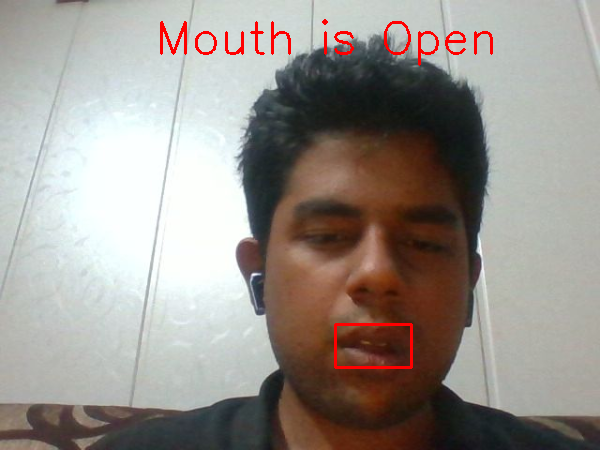

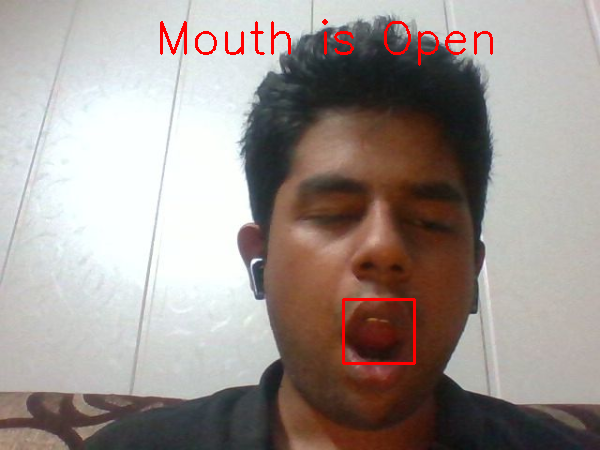

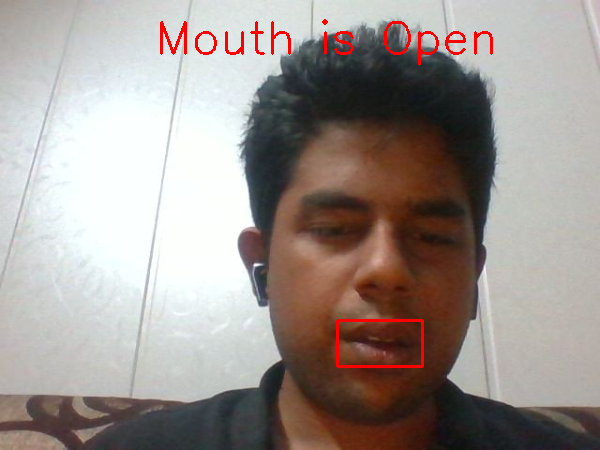

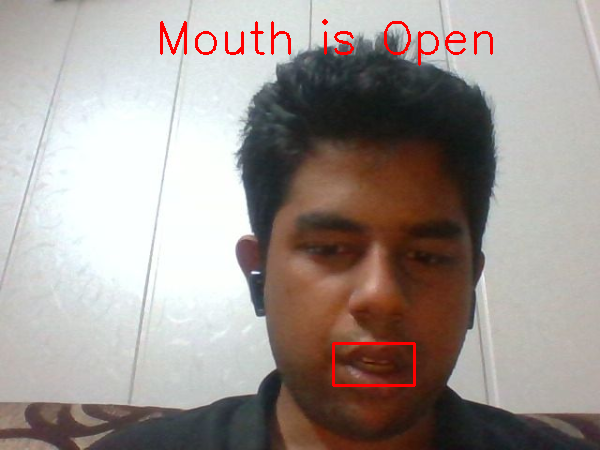

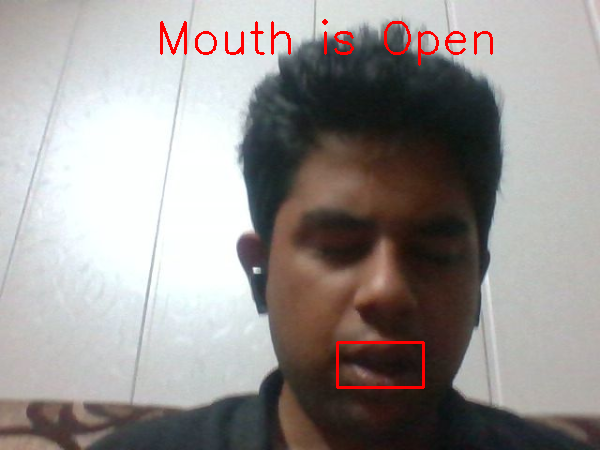

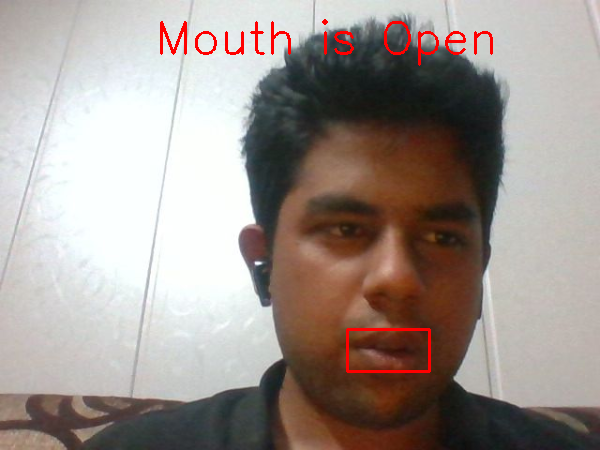

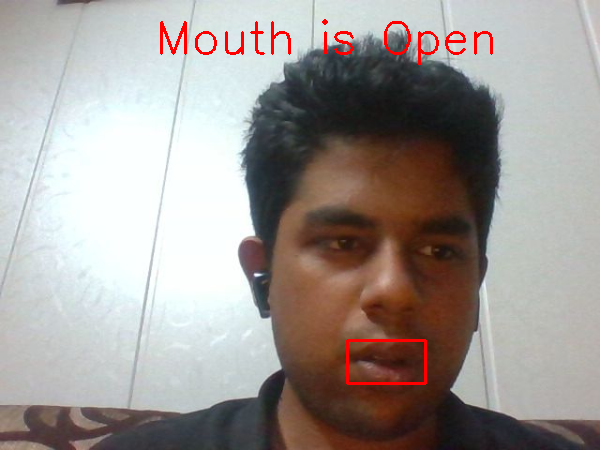

KeyboardInterrupt: ignored

In [14]:
# Loading Classifiers
face_detect = cv2.CascadeClassifier("face_detect.xml")
landmark_detect = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



# Capturing live video stream with help of Javascript Helper Function

cap = cv2.VideoCapture(0)
video_stream()
label_html = "Detecting ..."
bbox = ''
count = 0 
detector = dlib.get_frontal_face_detector()

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # Reading image from video stream 
  frame = js_to_image(js_reply["img"])

	
  frame = imutils.resize(frame, width=600)


  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	# Detecting the features
  faces = face_detect.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100),	flags=cv2.CASCADE_SCALE_IMAGE)

	
  for (x, y, w, h) in faces:
		
	  rect = dlib.rectangle(int(x), int(y), int(x + w),
		  int(y + h))		
	  landmark = landmark_detect(gray, rect)
	  landmark = face_utils.shape_to_np(landmark)

		
	  (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
		
	  mouth = landmark[mStart:mEnd]		
		# If mouth was detected, we will get the the x,y coordinates of the detected feature
	  boundRect = cv2.boundingRect(mouth)
	  cv2.rectangle(frame,
					  (int(boundRect[0]), int(boundRect[1])),
					  (int(boundRect[0] + boundRect[2]),  int(boundRect[1] + boundRect[3])), (0,0,255), 2)		
	  hsv = cv2.cvtColor(frame[int(boundRect[1]):int(boundRect[1] + boundRect[3]),int(boundRect[0]):int(boundRect[0] + boundRect[2])], cv2.COLOR_RGB2HSV)
	  sum_saturation = np.sum(hsv[:, :, 1])
	  area = int(boundRect[2])*int(boundRect[3])
	  avg_saturation = sum_saturation / area		
	  if abs(int(boundRect[1])-int(boundRect[1] + boundRect[3]))>=abs((int(boundRect[0] + boundRect[2])-int(boundRect[0]))/2):
			# Checking whether mouth is open or not
		  cv2.putText(frame, "Mouth is Open", (155, 53), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255),
						2)	
			
  cv2_imshow(frame)	
  key = cv2.waitKey(1) & 0xFF
  if key == 27:
	  break

cv2.destroyAllWindows()
vs.stop()